# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from numpy import log
import pmdarima as pm
import itertools
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import shap
from sklearn.metrics import *

# Load data

In [2]:
#read the csv file
df = pd.read_csv('new_final.csv')

df.head()

,Month,Sun_Hours,HPI,Unemployment_Rate,Total_Crimes
0,2017-01,2.1,118.06,4.6,144
1,2017-02,2.0,118.34,4.6,166
2,2017-03,3.8,118.02,4.5,194
3,2017-04,6.0,119.10,4.4,169
4,2017-05,6.3,119.38,4.4,169


# Data cleaning

In [3]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.set_index('Month')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2017-01-01 to 2021-12-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sun_Hours          60 non-null     float64
 1   HPI                60 non-null     float64
 2   Unemployment_Rate  60 non-null     float64
 3   Total_Crimes       60 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 2.3 KB


In [4]:
#summary statistics
df.describe()

,Sun_Hours,HPI,Unemployment_Rate,Total_Crimes
count,60.000000,60.000000,60.000000,60.000000
mean,4.391667,120.111500,4.260000,127.666667
std,2.155898,3.524746,0.382764,38.233301
min,1.000000,115.090000,3.800000,36.000000
25%,2.450000,118.050000,4.000000,102.500000
50%,4.350000,119.100000,4.200000,134.000000
75%,5.925000,121.570000,4.500000,158.000000
max,9.700000,129.720000,5.200000,194.000000


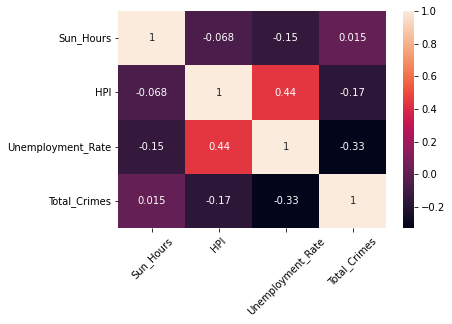

In [5]:
sns.heatmap(df.corr(),annot=True)
plt.xticks(rotation=45);

# Train and Test Set


In [6]:
def train_test(target, features):
    # creates train and test variables
    X_train = df[df.index.year <= 2020][features]
    X_test = df[df.index.year == 2021][features]

    y_train = df[df.index.year <= 2020][target]
    y_test = df[df.index.year == 2021][target]

    return X_train, X_test, y_train, y_test

# SARIMA Models
We have three exogenous variables and 1 endogenous y variable. The 3 exo variables are `Sun_Hours`, `HPI` and `Unemployment_Rate`. To see which which variables are most important, we pass combinations of each variable to the model to test the model fit. 

`HPI` and `Unemployment_Rate` are the most correlated.

In [11]:
def SARIMAX(target, features, n_periods, label):
    '''
    INPUT: 
    required target and feature names
    n_periods: number of months to start forecasting from. eg: 12 = 2021, 24 = 2021 & 2022, and so on
    label: labelling of prediction plot

    OUTPUT:
    SARIMA model with inputs and prediction plot
    '''
    X_train, X_test, y_train, y_test = train_test(target, features)
    
    model = pm.auto_arima(y_train, exogenous=X_train,
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    print(model.summary())

    n_periods = n_periods
    fitted, confint = model.predict(n_periods=n_periods, 
                                    exogenous=df.tail(n_periods)[features], 
                                    return_conf_int=True)

    index_of_fc = pd.date_range(df.index[-12], periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(16,8))
    plt.plot(df['Total_Crimes'],label='True Values')
    plt.plot(fitted_series, color='orange', label='Predicted Values')
    plt.plot(df[df.index.year==2021]['Total_Crimes'],label='Validation Period',c='green')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.legend(loc='upper left')
    plt.title("SARIMAX {} Forecast".format(label))
    plt.show()

    
    y_true = y_test
    y_hat = model.predict(n_periods, X_test)
    print('\n')
    print('Test RMSE: {:.4f}'.format(sqrt(mean_squared_error(y_true, y_hat)))) 
    print('Test MAE: {:.4f}'.format(mean_absolute_error(y_true, y_hat)))
    print('Test R2: {:.4f}'.format(r2_score(y_true, y_hat)))
    return model


#### MODEL1: Model with **the two most correlated** features.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=486.415, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=492.714, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=451.995, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=467.218, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=490.824, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=453.726, Time=0.26 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=453.098, Time=0.50 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=453.229, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=451.283, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=453.216, Time=0.65 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=451.161, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=452.146, Time=0.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=453.172, Time=0.48 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   

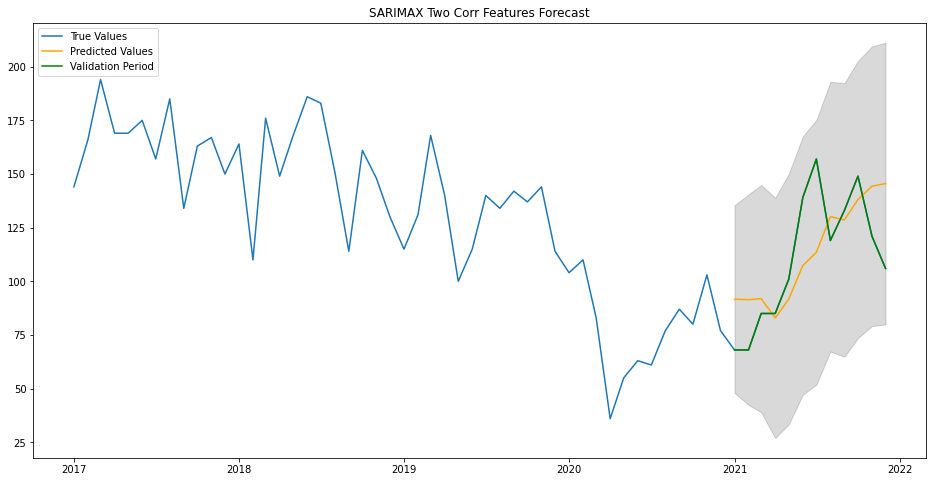



Test RMSE: 23.2965
Test MAE: 19.1511
Test R2: 0.3594


In [12]:
model1 = SARIMAX(target='Total_Crimes', features=['HPI','Unemployment_Rate'], n_periods=12, label='Two Corr Features')

#### `MODEL 2`: Check fit with **all** features 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=487.928, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=493.965, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=453.872, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=469.000, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=491.965, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=455.283, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=454.957, Time=0.74 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=455.148, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=453.203, Time=0.26 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=455.131, Time=0.51 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=452.981, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=453.595, Time=0.27 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=454.988, Time=0.45 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   

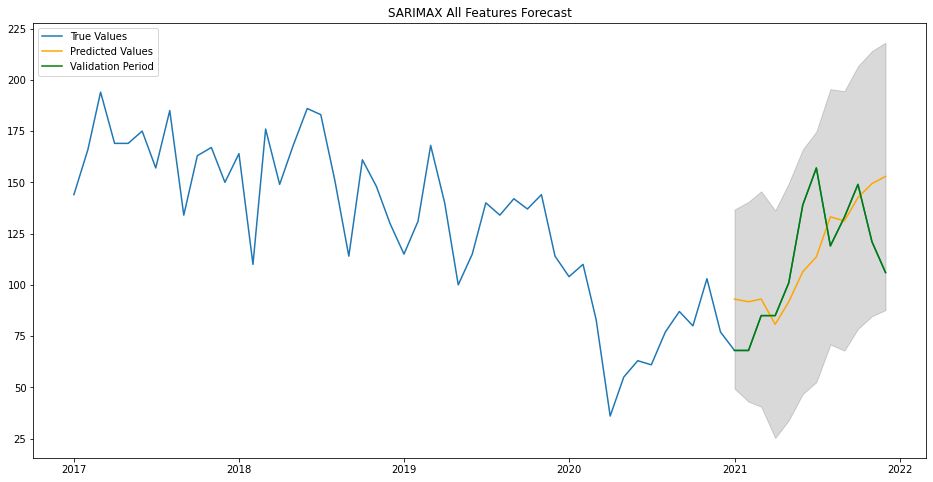



Test RMSE: 25.0897
Test MAE: 20.3380
Test R2: 0.2570


In [13]:
model2 = SARIMAX(target='Total_Crimes', features=['Sun_Hours','HPI','Unemployment_Rate'], n_periods=12, label='All Features')

#### MODEL 3: Check fit with **no** features 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-966.647, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-968.647, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-964.647, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-964.647, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-970.647, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-966.647, Time=0.20 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-964.647, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-966.647, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-966.647, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-964.647, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.121 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelih

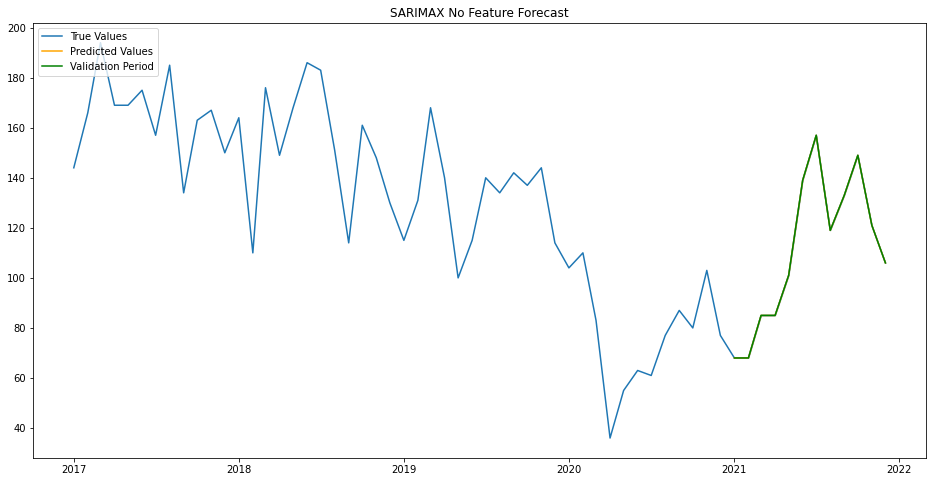



Test RMSE: 0.0000
Test MAE: 0.0000
Test R2: 1.0000


In [10]:
model3 = SARIMAX(target='Total_Crimes', features=['Total_Crimes'], n_periods=12, label='No Feature')